# HESTON MODEL
- Data Collection
- Heston Calibrate
- Hetsom Simulate

<a name='library'></a>
## Libraries

In [2]:
!pip install yfinance
!pip install --upgrade pandas-datareader


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 22.9 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
#import quantstats as qs
import yfinance as yf
import statsmodels.api as sm

import numpy as np 
import pandas_datareader as web 
import seaborn
import scipy.stats as stats
from numba import jit



<a name='data'></a>

## Retrieving Data

In [4]:
def get_data(start,end,data_source = "yahoo",tickers= []):
        symbols=[]
        if(len(tickers) == 0):
            tickers=tickers

        for ticker in tickers:  
            try:   
                r = web.DataReader(ticker,data_source, start,end) 
            except :
                print(ticker)
            
                continue  
            # add a symbol column   
            r['Symbol'] = ticker    
            symbols.append(r)
        # concatenate into df
        df = pd.concat(symbols)
        df = df.reset_index()
        df = df[['Date', 'Adj Close', 'Symbol']]
        df_pivot=df.pivot('Date','Symbol','Adj Close').reset_index()
        df_pivot.set_index("Date",inplace=True)
        return df_pivot

# no of years of data needed 
years_data = 1
stock_data = get_data(tickers=['CSGN.SW'],start =DT.datetime.now() -DT.timedelta(days=365*years_data),end= DT.datetime.now() )
stock_data.tail()

Symbol,CSGN.SW
Date,
2022-11-07,4.070
2022-11-08,4.139
2022-11-09,4.006
2022-11-10,4.089
2022-11-11,4.267


In [5]:
# Intial Barrier Level
display(stock_data.loc[pd.Timestamp(2022,8,15)])
intial_lvl = stock_data.loc[pd.Timestamp(2022,8,15)].values[0]
barrier_lvl = intial_lvl * 0.5
conversion_ratio = 184.5018
print("Initial  Level => ",intial_lvl)
print("Barrier Level => ",barrier_lvl)

Symbol
CSGN.SW    5.42
Name: 2022-08-15 00:00:00, dtype: float64

Initial  Level =>  5.420000076293945
Barrier Level =>  2.7100000381469727


In [6]:
prices = np.array(stock_data["CSGN.SW"])

Estimate v and sd from historical data (yearly... right?)

In [7]:
def get_statistics(prices, dt):
  log_data = np.log(prices)
  log_returns = log_data[1:] - log_data[:-1]
  v = np.mean(log_returns)/dt
  sd = np.std(log_returns)/np.sqrt(dt)
  return v, sd

In [8]:
dt=1/252
v, sd = get_statistics(prices, dt)
print("v: ", v)
print("sd: ", sd)

v:  -0.755645894894332
sd:  0.4785572959526592


Payoff function:

In [9]:
# without early redemption or callable
def payoff(Spath):
  Smin = min(Spath)
  # if closes at or above initial level
  if Spath[-1] >= intial_lvl:
    return 1000+100 
  # if barrier occurs
  elif Smin <= barrier_lvl:
    return Spath[-1]*184.5-18+100
  # if no barrier occurs
  else:
    return 1000+100

In [10]:
# without early redemption or callable
def payoff(Spath, t, s0 = 5.42, denom = 1000):
  # determine coupon amount
  coupon = 0.1
  if t > 0.75:
    coupon = 0.025
  elif t > 0.5:
    coupon = 0.05
  elif t > 0.25:
    coupon = 0.075
  Smin = min(Spath)
  # if closes at or above initial level
  if Spath[-1] >= 5.42:
    return denom+coupon*denom
  # if barrier occurs
  elif Smin <= 2.71:
    return Spath[-1]*184.5+coupon*denom
  # if no barrier occurs
  else:
    return denom+coupon*denom

In [11]:
price_list = [1000] #on 15 Aug (initial fixing date)
price_list.append(997.9)
price_list.append(986.6)
price_list.append(985.2)
price_list.append(974.4)
price_list.append(970.9) #22 aug
price_list.append(976.6)
price_list.append(974.3)
price_list.append(982.7)
price_list.append(975.3)
price_list.append(969.6) #29 aug
price_list.append(969.4)
price_list.append(966.7)
price_list.append(951.8)
price_list.append(967.1)
price_list.append(945.3) #5 sep
price_list.append(945.6)
price_list.append(943.1)
price_list.append(948.6)
price_list.append(957.2)
price_list.append(963.6) #12 Sep
price_list.append(948.8) #14 sep
price_list.append(952.8)
price_list.append(945.8)
price_list.append(946.1) #19 sep
price_list.append(937.1)
price_list.append(934.1)
price_list.append(919.5)
price_list.append(852.3) #2
price_list.append(848.8) #26 sep
price_list.append(837.0)
price_list.append(803.2)
price_list.append(811.0)
price_list.append(825.9)
price_list.append(788.0) # 3 oct
price_list.append(810.8)
price_list.append(780.8)
price_list.append(714.3)
price_list.append(773.2)
price_list.append(778.8) # 10 oct
price_list.append(779.6)
price_list.append(762.5)
price_list.append(785.7)
price_list.append(781.2)
price_list.append(788.5) #17 oct
price_list.append(798.6)
price_list.append(800.0)
price_list.append(795.8)
price_list.append(801.6)
price_list.append(815.4) # 24 oct
price_list.append(828.4)
price_list.append(825.0)
price_list.append(774.5)
price_list.append(789.9)
price_list.append(806.6) # 31 oct
price_list.append(818.2)
price_list.append(823.6)
price_list.append(820.7) # 3 nov

In [12]:
start_date = "2022-08-15"
today = DT.date.today()
tickers=["CSGN.SW"]
backtest_period = yf.download(tickers, 
                      start=start_date, 
                      end=today, 
                      progress=False)
print("number of days: ",len(backtest_period))
Nsim=10000
dt = 1/252
r = 3.26/100
rnv_v = r - sd**2/2
T = 1
t = 0
m = int(T/dt)

number of days:  65


In [13]:
prices_array=[]
for date in backtest_period.index:
  end_date = date-DT.timedelta(days=1)+ DT.timedelta(days=1)
  start_date = end_date - DT.timedelta(days=365)
  data = yf.download(tickers, 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
  #print(np.array(data["Adj Close"]).shape)
  prices_array.append(np.array(data["Adj Close"]))

In [14]:
backtest_period.reset_index(inplace=True)
backtest_period.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-08-15,5.504,5.504,5.388,5.420,5.420,5798099
1,2022-08-16,5.450,5.490,5.396,5.430,5.430,5771557
2,2022-08-17,5.498,5.506,5.208,5.208,5.208,10737415
3,2022-08-18,5.220,5.274,5.192,5.250,5.250,4868159
4,2022-08-19,5.230,5.230,5.046,5.046,5.046,9126333



<a name='heston'></a>
### Heston Model Simulate Asset Prices

https://hal.sorbonne-universite.fr/hal-02273889/document

In [15]:
def heston_model_sim(S0, v0, rho, kappa, theta, sigma,T, N, M):
   
    # Inputs:
    #  - S0, v0: initial parameters for asset and variance
    #  - rho   : correlation between asset returns and variance
    #  - kappa : rate of mean reversion in variance process
    #  - theta : long-term mean of variance process
    #  - sigma : vol of vol / volatility of variance process
    #  - T     : time of simulation
    #  - N     : number of time steps
    #  - M     : number of scenarios / simulations
    
    # Outputs:
    # - asset prices over time (numpy array)
    # - variance over time (numpy array)

    # initialise other parameters

    dt=T/N
    mu = np.array([0,0])
    cov = np.array([[1,rho],
                    [rho,1]])
    S = np.full(shape=(N+1,M), fill_value=S0)
    v = np.full(shape=(N+1,M), fill_value=v0)

     # sampling correlated brownian motions under risk-neutral measure
    Z = np.random.multivariate_normal(mu, cov, (N,M))
    print(S.shape)
    print(v.shape)
    for i in range(1,N+1):
        S[i] = S[i-1] * np.exp( (r - 0.5*v[i-1])*dt + np.sqrt(v[i-1] * dt) * Z[i-1,:,0] )
        v[i] = np.maximum(v[i-1] + kappa*(theta-v[i-1])*dt + sigma*np.sqrt(v[i-1]*dt)*Z[i-1,:,1],0)
    
    return S, v


In [16]:
rho_p = 0.98
rho_n = -0.98
So=intial_lvl
T=1
N=252
M = 1000
# Heston dependent parameters
kappa = 3              # rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # long-term mean of variance under risk-neutral dynamics
v0 = 0.25**2           # initial variance under risk-neutral dynamics
rho = 0.7              # correlation between returns and variances under risk-neutral dynamics
sigma = 0.6            # volatility of volatility

S_p,v_p = heston_model_sim(So, v0, rho_p, kappa, theta, sigma,T, N, M)
S_n,v_n = heston_model_sim(So, v0, rho_n, kappa, theta, sigma,T, N, M)


(253, 1000)
(253, 1000)
(253, 1000)
(253, 1000)


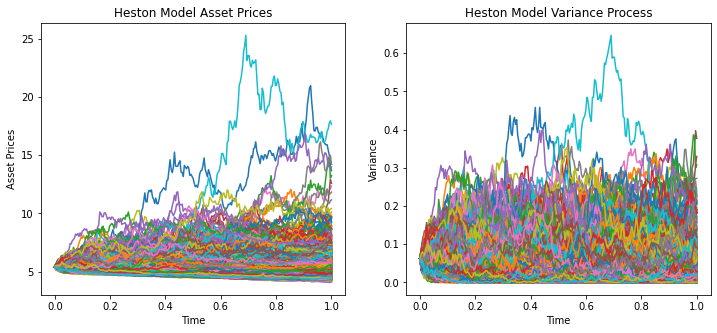

In [17]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,T,N+1)
ax1.plot(time,S_p)
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
ax2.plot(time,v_p)
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
plt.show()

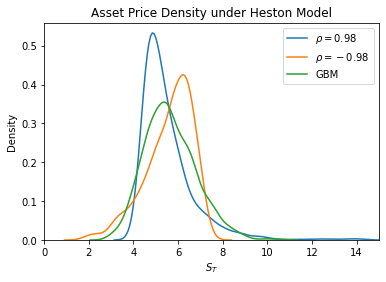

In [18]:
# simulate gbm process at time T
import seaborn as sb
gbm = So*np.exp( (r - theta**2/2)*T + np.sqrt(theta)*np.sqrt(T)*np.random.normal(0,1,M) )
fig, ax = plt.subplots()
ax = sb.kdeplot(S_p[-1], label=r"$\rho= 0.98$", ax=ax)
ax = sb.kdeplot(S_n[-1], label=r"$\rho= -0.98$", ax=ax)
ax = sb.kdeplot(gbm, label="GBM", ax=ax)
plt.title(r'Asset Price Density under Heston Model')
plt.xlim([0, 15])
plt.xlabel('$S_T$')
plt.ylabel('Density')
plt.legend()
plt.show()

### Parameter Calibration 
based on Data form date 4-Nov-2022

https://calebmigosi.medium.com/build-the-heston-model-from-scratch-in-python-part-ii-5971b9971cbe

### Using Bloomberg excel files

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import glob
path='/content/drive/MyDrive/Bloomberg Data/'
folders=glob.glob(path+'/*')


In [21]:

import pandas as pd
options={}
for i in folders:
  csvs= glob.glob(i+'/*.csv')
  options[i]=[]
  for j in csvs:
    option_data=pd.read_csv(j,header=[1])[['Strike','Mid','ExDt']].dropna(how='all').set_index('Strike')
    option_data['ExDt']=option_data['ExDt'].apply(lambda x: DT.datetime.strptime(x,'%m/%d/%y').date())
    maturties=option_data['ExDt'].unique()
    if(len(maturties)==1):
      option_data.drop(columns='ExDt',inplace=True)
      option_data.columns =[maturties[0]]
      option_data.drop_duplicates(inplace=True)
      option_data=option_data.reset_index().drop_duplicates(subset='Strike', keep='first').set_index('Strike').sort_index()
      options[i].append(option_data)
    else:
      for k in maturties:
        maturity_option_data = option_data[option_data['ExDt']==k]
        maturity_option_data.drop(columns='ExDt',inplace=True)
        maturity_option_data.columns =[k]
        maturity_option_data.drop_duplicates(inplace=True)
        maturity_option_data=maturity_option_data.reset_index().drop_duplicates(subset='Strike', keep='first').set_index('Strike').sort_index()
        options[i].append(maturity_option_data)

    #options[i].append(option_data)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [22]:
curr_date = list(options.keys())[0]
curr_date

'/content/drive/MyDrive/Bloomberg Data/8nov22'

In [23]:
options_data=-1
for i in options[curr_date]:
  if(type(options_data)==int):
    options_data=i
  else:
    try:
      options_data=options_data.merge(i,left_on='Strike',right_on='Strike',suffixes=('',''),how='outer')
    except:
      pass

In [24]:
maturities = [(date - DT.date(2022,8,15)).days/365.25  for date in options_data.columns]
options_data.columns=maturities
options_data=options_data.transpose().fillna(method='ffill').transpose()
print(options_data.shape)

options_data.dropna(how='any',thresh=int(options_data.shape[1]*0.8),axis=0,inplace=True)
print(options_data.shape)
options_data.dropna(how='any',thresh=int(options_data.shape[0]*0.8),axis=1,inplace=True)
print(options_data.shape)

options_data = options_data.sort_index().fillna(method='ffill')
options_data=options_data.transpose().sort_index().transpose()
maturities

(75, 12)
(44, 12)
(44, 11)


[0.8350444900752909,
 1.3333333333333333,
 1.8507871321013005,
 2.349075975359343,
 2.847364818617385,
 0.432580424366872,
 0.33675564681724846,
 1.0841889117043122,
 3.345653661875428,
 4.342231348391513,
 0.5859000684462696,
 0.2600958247775496]

In [25]:
options_data.head()


,0.260096,0.336756,0.432580,0.585900,1.084189,1.333333,1.850787,2.349076,2.847365,3.345654,4.342231
Strike,,,,,,,,,,,
0.6,0.00,0.00,0.00,0.00,0.00,3.31,0.00,0.00,0.00,0.00,0.00
0.8,3.12,3.12,3.12,3.12,3.12,3.12,3.12,3.12,3.12,3.12,3.12
1.0,0.00,0.00,0.00,0.00,0.00,2.93,2.93,0.00,0.00,0.00,0.00
1.2,2.75,2.75,2.75,2.75,2.75,2.75,2.75,2.75,2.75,2.75,2.75
1.3,2.65,2.64,2.64,2.65,2.93,2.64,2.64,2.64,2.64,2.93,2.93


In [26]:
volSurface=options_data.copy()
volSurface=volSurface.transpose()
volSurface

Strike,0.6,0.8,1.0,1.2,1.3,1.4,1.5,1.6,1.7,1.8,...,9.5,10.0,11.0,12.0,13.0,14.0,16.0,18.0,20.0,24.0
0.260096,0.00,3.12,0.00,2.75,2.65,2.55,2.46,2.36,2.27,2.170,...,0.095,0.04,0.11,0.01,0.03,0.11,0.08,0.03,0.05,0.04
0.336756,0.00,3.12,0.00,2.75,2.64,2.57,2.45,2.40,2.27,2.280,...,0.095,0.17,0.08,0.01,0.07,0.11,0.08,0.03,0.05,0.04
0.432580,0.00,3.12,0.00,2.75,2.64,2.57,2.45,2.40,2.27,2.230,...,0.095,0.17,0.08,0.14,0.07,0.11,0.08,0.03,0.05,0.04
0.585900,0.00,3.12,0.00,2.75,2.65,2.55,2.46,2.36,2.27,2.170,...,0.095,0.04,0.11,0.01,0.03,0.11,0.08,0.03,0.05,0.04
1.084189,0.00,3.12,0.00,2.75,2.93,2.83,2.73,2.64,2.55,2.455,...,0.095,0.12,0.11,0.01,0.07,0.11,0.08,0.03,0.05,0.04
1.333333,3.31,3.12,2.93,2.75,2.64,2.57,2.45,2.40,2.27,2.230,...,0.095,0.17,0.08,0.14,0.07,0.11,0.08,0.03,0.05,0.04
1.850787,0.00,3.12,2.93,2.75,2.64,2.57,2.45,2.40,2.27,2.230,...,0.095,0.17,0.08,0.14,0.07,0.11,0.08,0.03,0.05,0.04
2.349076,0.00,3.12,0.00,2.75,2.64,2.57,2.45,2.40,2.27,2.230,...,0.095,0.17,0.08,0.14,0.07,0.11,0.08,0.03,0.05,0.04
2.847365,0.00,3.12,0.00,2.75,2.64,2.57,2.45,2.40,2.27,2.230,...,0.095,0.17,0.08,0.14,0.07,0.11,0.08,0.03,0.05,0.04
3.345654,0.00,3.12,0.00,2.75,2.93,2.83,2.73,2.64,2.55,2.455,...,0.095,0.12,0.11,0.01,0.07,0.11,0.08,0.03,0.05,0.04


In [27]:
volSurface.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 11 entries, 0.2600958247775496 to 4.342231348391513
Data columns (total 44 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.6     11 non-null     float64
 1   0.8     11 non-null     float64
 2   1.0     11 non-null     float64
 3   1.2     11 non-null     float64
 4   1.3     11 non-null     float64
 5   1.4     11 non-null     float64
 6   1.5     11 non-null     float64
 7   1.6     11 non-null     float64
 8   1.7     11 non-null     float64
 9   1.8     11 non-null     float64
 10  1.9     11 non-null     float64
 11  2.0     11 non-null     float64
 12  2.2     11 non-null     float64
 13  2.4     11 non-null     float64
 14  2.6     11 non-null     float64
 15  2.8     11 non-null     float64
 16  3.0     11 non-null     float64
 17  3.2     11 non-null     float64
 18  3.4     11 non-null     float64
 19  3.6     11 non-null     float64
 20  3.8     11 non-null     float64
 21  4.0    

## Heston

- Asset Pricing using EuelrApproximation
- Model Calibation using closed form solution of European Call options([Refrence Tutorial](https://quantpy.com.au/stochastic-volatility-models/heston-model-calibration-to-option-prices/))
- Least Squarre estimate to calibrate the paarmeter
- Use Parameters to predict product price on 8th November

In [1]:
!pip install nelson_siegel_svensson


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize 
from datetime import datetime as dt
# from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

In [29]:
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    
    # constants
    a = kappa*theta
    b = kappa+lambd
    
    # common terms w.r.t phi
    rspi = rho*sigma*phi*1j
    
    # define d parameter given phi and b
    d = np.sqrt( (rho*sigma*phi*1j - b)**2 + (phi*1j+phi**2)*sigma**2 )
    
    # define g parameter given phi, b and d
    g = (b-rspi+d)/(b-rspi-d)
    
    # calculate characteristic function by components
    exp1 = np.exp(r*phi*1j*tau)
    term2 = S0**(phi*1j) * ( (1-g*np.exp(d*tau))/(1-g) )**(-2*a/sigma**2)
    exp2 = np.exp(a*tau*(b-rspi+d)/sigma**2 + v0*(b-rspi+d)*( (1-np.exp(d*tau))/(1-g*np.exp(d*tau)) )/sigma**2)
    return exp1*term2*exp2

In [30]:
def integrand(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K*heston_charfunc(phi,*args)
    denominator = 1j*phi*K**(1j*phi)
    return numerator/denominator

In [31]:
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    P, umax, N = 0, 100, 10000
    dphi=umax/N #dphi is width
    for i in range(1,N):
        # rectangular integration
        phi = dphi * (2*i + 1)/2 # midpoint to calculate height
        numerator = np.exp(r*tau)*heston_charfunc(phi-1j,*args) - K * heston_charfunc(phi,*args)
        denominator = 1j*phi*K**(1j*phi)
        
        P += dphi * numerator/denominator
        
    return np.real((S0 - K*np.exp(-r*tau))/2 + P/np.pi)

In [32]:
def heston_price(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)
    
    real_integral, err = np.real( quad(integrand, 0, 100, args=args) )
    
    return (S0 - K*np.exp(-r*tau))/2 + real_integral/np.pi

In [33]:
date ='11/08/2022' # fomat mm/dd/yyyy
rate=pd.read_csv('/content/daily-treasury-rates.csv',index_col=[0])
rate
rates=np.array(rate.loc[date]).astype(float)/100
maturities = np.array([1/12, 2/12, 3/12, 4/12,6/12, 1, 2, 3, 5, 7, 10, 20, 30])
rate_dataframe = pd.DataFrame(rates,maturities).dropna(how='any')
maturities=rate_dataframe.index.to_numpy()
rates=rate_dataframe[0].to_numpy()
#NSS model calibrate
curve_fit, status = calibrate_nss_ols(maturities,rates) 
curve_fit

NelsonSiegelSvenssonCurve(beta0=0.045808326268519384, beta1=-0.012063374558957824, beta2=0.029261495355632702, beta3=-0.015016994340857587, tau1=0.42380713383947577, tau2=4.535874336805877)

In [34]:
# Convert our vol surface to dataframe for each option price with parameters
volSurfaceLong = volSurface.melt(ignore_index=False).reset_index()
volSurfaceLong.columns = ['maturity', 'strike', 'price']
# Calculate the risk free rate for each maturity using the fitted yield curve
volSurfaceLong['rate'] = volSurfaceLong['maturity'].apply(curve_fit)

In [ ]:

# Define variables to be used in optimization
S0 = 1.55 # last raded pric eof option on 8th November
r = volSurfaceLong['rate'].to_numpy('float')
K = volSurfaceLong['strike'].to_numpy('float')
tau = volSurfaceLong['maturity'].to_numpy('float')
P = volSurfaceLong['price'].to_numpy('float')
params = {"v0": {"x0": 0.1, "lbub": [1e-3,0.5]}, 
          "kappa": {"x0": 3, "lbub": [1,20]},
          "theta": {"x0": 0.05, "lbub": [1e-3,0.5]},
          "sigma": {"x0": 0.3, "lbub": [1e-2,1]},
          "rho": {"x0": -0.8, "lbub": [-1,0.5]},
          "lambd": {"x0": 0.03, "lbub": [-1,1]},
          }
x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]
def SqErr(x):
    v0, kappa, theta, sigma, rho, lambd = [param for param in x]
    
    # Attempted to use scipy integrate quad module as constrained to single floats not arrays
    # err = np.sum([ (P_i-heston_price(S0, K_i, v0, kappa, theta, sigma, rho, lambd, tau_i, r_i))**2 /len(P) \
    #               for P_i, K_i, tau_i, r_i in zip(marketPrices, K, tau, r)])
    
    # Decided to use rectangular integration function in the end

    err = np.sum( (P-heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r))**2 /len(P) )
    
    # Zero penalty term - no good guesses for parameters
    pen = 0 #np.sum( [(x_i-x0_i)**2 for x_i, x0_i in zip(x, x0)] )
          
    return err + pen
result = minimize(SqErr, x0, tol = 1e-3, method='SLSQP', options={'maxiter': 1e3 }, bounds=bnds)
v0, kappa, theta, sigma, rho, lambd = [param for param in result.x]
v0, kappa, theta, sigma, rho, lambd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


(0.3182575332059523,
 2.9776119860839447,
 0.30283696831102463,
 0.399752380584235,
 -0.72355473004052,
 -0.2815595904460303)

In [41]:
heston_prices = heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r)
volSurfaceLong['heston_price'] = heston_prices

In [42]:
# calculating the difference between the maturity date the date we are calculating the price for
date='2022-11-08'
delta = 252 - backtest_period[backtest_period['Date']==date].index.values[0]
tau=delta/252
# stock price on 8th Nov
st =stock_data.loc[pd.Timestamp(2022,11,7)].values[0]
print(f'Asset Price at {st}')
r=curve_fit(tau)

Asset Price at 4.070000171661377


(192, 10000)
(192, 10000)


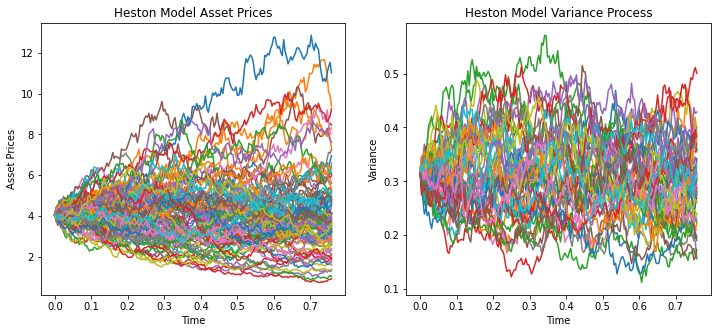

In [43]:
N=252
M = 10000
S_p,v_p = heston_model_sim(st, v0, rho,kappa, theta, sigma, tau, delta, M)

fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(12,5))
time = np.linspace(0,tau,delta+1)
ax1.plot(time,S_p[:,:100])
ax1.set_title('Heston Model Asset Prices')
ax1.set_xlabel('Time')
ax1.set_ylabel('Asset Prices')
ax2.plot(time,v_p[:,:50])
ax2.set_title('Heston Model Variance Process')
ax2.set_xlabel('Time')
ax2.set_ylabel('Variance')
# ax1.set_ylim(1,100)
plt.show()

In [44]:
payoff_sim = np.exp(-r*tau)*np.apply_along_axis(payoff, 0, S_p,1-tau)
heston_estimate=np.mean(payoff_sim)
print(f'The Price estimate on {date} using Heston model without callable => {heston_estimate}')

The Price estimate on 2022-11-08 using Heston model without callable => 847.6606580151023


In [47]:
def redemption_cost(t, denom = 1000):
  # determine coupon amount
  # t = 0.5, 0.75 only
  if t < 0.5:
    raise Exception("cannot redeem yet")
  elif t < 0.75:
    coupon = 0.05
  elif t < 1.0:
    coupon = 0.075
  else:
    coupon = 0.1
  return denom+coupon*denom

In [58]:
returns_sim=S_p.transpose().copy()
returns_sim.shape

(10000, 192)

In [66]:
start_date = "2022-08-15"
today = "2022-11-09" # end date of our backetsting
tickers=["CSGN.SW"]
backtest_period = yf.download(tickers, 
                      start=start_date, 
                      end=today, 
                      progress=False)
print("number of days: ",len(backtest_period))
backtest_period.reset_index(inplace=True)
backtest_period.tail()

number of days:  62


,Date,Open,High,Low,Close,Adj Close,Volume
57,2022-11-02,4.249,4.269,4.112,4.120,4.120,10269748
58,2022-11-03,4.080,4.144,4.000,4.101,4.101,11971648
59,2022-11-04,4.100,4.195,4.021,4.186,4.186,12347605
60,2022-11-07,4.180,4.207,4.041,4.070,4.070,13131077
61,2022-11-08,4.029,4.148,4.016,4.139,4.139,13292950


In [70]:
from sklearn.linear_model import LinearRegression
payoff_sim = np.apply_along_axis(payoff, 0, S_p,1-tau)
date = backtest_period[backtest_period['Date']==date].index.values[0]
exdates = [126-date, 189-date]
exdates=[i  for i in exdates if i>=0] # removing exdates if it is negative i.e redemption date has passed
extimes = len(exdates)
#print(extimes)
# initialize matrix
V = np.zeros((Nsim, extimes+1))
exmat = np.zeros((Nsim, extimes)) # exmat[:, -1] = 1

# V = np.insert(V, extimes, payoff_sim, axis=1)
V[:,-1] = payoff_sim
dt = 1/delta
#print(dt)
previousstep = delta
for i,j in enumerate(exdates[::-1]):
  currentstep = j
  # assume all are ITM points
  Y=np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)] # discounting from previuosstep-currentstep
  X=returns_sim[:,currentstep]
  X2=X**2
  #print(X.shape)
  X = np.reshape(X, (-1,1))
  #print(X.shape)
  X = np.insert(X, 1, X2, axis=1)
  #print(X.shape)
  #print(X, Y)
  LR = LinearRegression().fit(X, Y)
  F = LR.predict(X)
  #print(F)
  #print(redemption_cost((currentstep+date)*dt))
  shouldRedeem = np.where(redemption_cost((currentstep+date)*dt) < F, 1, 0)
  #print(sum(shouldRedeem))
  exmat[:,-(i+1)] = shouldRedeem
  newvalues = np.where(shouldRedeem, redemption_cost((currentstep+date)*dt), np.exp(-r*(previousstep-currentstep)*dt)*V[:,-(i+1)])
  V[:, -(i+2)] = newvalues
  previousstep=j

print(previousstep)
v0=np.exp(-r*(previousstep-0)*dt)*np.mean(V[:,0])
  # ev = np.mean(payoff_sim)
  # GBM_ev.append(v0)

heston_estimate=np.mean(payoff_sim)
# print(f'The Price estimate on {date} using Heston model => {heston_estimate}')
print(f'The Price estimate on {date} using Heston model => {v0}')

65
The Price estimate on 61 using Heston model => 838.1764179804187
